In [7]:
pip install matplotlib

     |████████████████████████████████| 7.9 MB 2.5 MB/s eta 0:00:01▉              | 4.4 MB 2.5 MB/s eta 0:00:02
     |████████████████████████████████| 260 kB 38.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 21.5 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 12.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tiktoken

     |████████████████████████████████| 961 kB 1.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:


import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3*config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer('bias', torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1,1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, channels
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        # transpose is done for efficiency optimization
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B, T, C)

        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size : int = 256
    vocab_size : int = 50257 
    n_layer : int = 12
    n_head : int = 12
    n_embd : int = 768

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # initalize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        # layer norm is by default set to what we want, no need to adjust it
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, "NANOGPT_SCALE_INIT"):
                std *= (2 * self.config.n_layer) ** -0.5 
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            # reasonable values are set based off a certain equation
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02 )



    def forward(self, idx, targets=None): # of the network
        B, T = idx.size() # batch and time dimension
        assert T <= self.config.block_size, f"maximum sequence length breached"
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos)
        tok_emb = self.transformer.wte(idx)

        x = tok_emb + pos_emb # hidden broadcast

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"

        print(sd_keys)

        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        with open('parvin_norm.txt', "r") as f:
            text = f.read()

        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // B * T} batches")

        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position+(B*T + 1)]
        x = (buf[:-1]).view(B, T)
        y = (buf[1:]).view(B,T)

        self.current_position += B * T
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0
        return x,y

device cpu
Loaded 361099 tokens
1 epoch = 722176 batches
loss 11.000304222106934, step 0, dt 331417.73ms
loss 8.837708473205566, step 1, dt 311759.64ms
loss 7.893680572509766, step 2, dt 303900.14ms
loss 7.560001373291016, step 3, dt 314490.51ms
loss 7.163389682769775, step 4, dt 310893.09ms
loss 14.443405151367188, step 5, dt 282262.09ms
loss 6.688471794128418, step 6, dt 284739.78ms
loss 6.522701740264893, step 7, dt 284529.61ms
loss 6.238023281097412, step 8, dt 287903.47ms
loss 5.948301792144775, step 9, dt 282186.82ms
loss 5.646151065826416, step 10, dt 278251.15ms
loss 5.34878396987915, step 11, dt 286461.67ms
loss 5.080937385559082, step 12, dt 282082.59ms
loss 4.704866409301758, step 13, dt 280383.17ms
loss 4.579735279083252, step 14, dt 280968.82ms
loss 4.3607916831970215, step 15, dt 277014.33ms
loss 4.171437740325928, step 16, dt 277294.02ms
loss 4.043392181396484, step 17, dt 283077.42ms
loss 3.918037176132202, step 18, dt 282457.72ms
loss 3.7625272274017334, step 19, dt 28

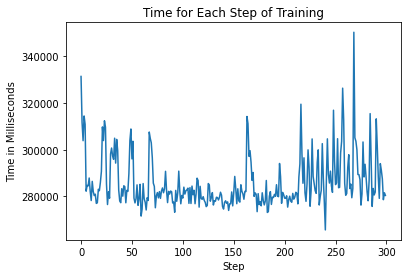

In [21]:
# ----------
# training
# ----------


import time
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"device {device}")

torch.manual_seed(1337)
if torch.cuda.is_available():
  torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=128, T=256)

model = GPT(GPTConfig())
model.to(device)

loss_arr = []

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(300):
    t0 = time.time() # start timer
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    #torch.cuda.synchronize() # synchronize with GPU
    t1 = time.time()
    dt = (t1-t0)*1000 # milliseconds difference
    print(f"loss {loss.item()}, step {i}, dt {dt:.2f}ms")
    loss_arr.append(dt)


#############################

!pip install matplotlib
import matplotlib.pyplot as plt

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the data
ax.plot(loss_arr)

# Set the title and labels
ax.set_title('Time for Each Step of Training')
ax.set_xlabel('Step')
ax.set_ylabel('Time in Milliseconds')

# Show the plot
plt.show()


In [13]:
# ----------
# sampling loop after the first training
# ----------

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"device {device}")

num_return_sequences = 5
max_length = 50

import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("ای دل عبث مخور غم دنیا را")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

torch.manual_seed(1337)
if torch.cuda.is_available():
  torch.cuda.manual_seed(1337)

while x.size(1) < max_length:
    with torch.no_grad():
        logits, _ = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        xcol = torch.gather(topk_indices, -1, ix)
        x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f">> {decoded}")

device cpu
>> ای دل عبث مخور غم دنیا راب�ت هال�ت
همیاهڨن� �وت
>> ای دل عبث مخور غم دنیا را�
ادی � �ننوو�م٩
� ٨
>> ای دل عبث مخور غم دنیا رام � بچاڨ دڌبهیهاااا�
>> ای دل عبث مخور غم دنیا رای��یۨ� ةی�درلم� ب�
>> ای دل عبث مخور غم دنیا راهریو  نا 
ت
�ا ةن����


In [23]:
# ----------
# from hugging face model
# ----------

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"device {device}")

torch.manual_seed(1337)
if torch.cuda.is_available():
  torch.cuda.manual_seed(1337)

model = GPT.from_pretrained('gpt2')
model.eval()
model.to(device)

num_return_sequences = 5
max_length = 100

import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("ای دل عبث مخور غم دنیا را")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

while x.size(1) < max_length:
    with torch.no_grad():
        logits, _ = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        xcol = torch.gather(topk_indices, -1, ix)
        x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f">> {decoded}")

device cpu
loading weights from pretrained gpt: gpt2
['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.2.ln_1.weight', 'transformer.h.2.ln_1.bias', 'transformer.h.2.a